In [1]:
import pandas as pd 
import numpy as np
from xgboost import XGBClassifier
import shap
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
train = pd.read_csv('../data/hk_tr.csv')
valid = pd.read_csv('../data/hk_val.csv')
test = pd.read_csv('../data/hk_te.csv')

In [3]:
print(train.columns)
print(valid.columns)
print(test.columns)

Index(['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC_re', 'WBC_re',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'Biopsy_HK'],
      dtype='object')
Index(['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC_re', 'WBC_re',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'Biopsy_HK'],
      dtype='object')
Index(['age', 'sex', 'HTN', 'DM', 'plt', 'tpro', 'alb', 'bun', 'cr', 'eGFR',
       'blood_dip', 'protein_dip', 'acr_urine', 'pcr_urine', 'glu',
       'glu_urine', 'esterase_urine', 'dysmorphism', 'RBC_re', 'WBC_re',
       'RBC_binary', 'WBC_binary', 'esterase_binary', 'Biopsy_HK'],
      dtype='object')


In [4]:
print(train.shape)
print(valid.shape)
print(test.shape)

(6171, 24)
(411, 24)
(1646, 24)


## Modeling

In [5]:
xgb = XGBClassifier(random_state = 2023, n_jobs=-1)

In [6]:
X_train = train.drop(['Biopsy_HK', 'RBC_re', 'WBC_re'], axis=1).copy()
y_train = train['Biopsy_HK'].copy()

X_valid = valid.drop(['Biopsy_HK', 'RBC_re', 'WBC_re'], axis=1).copy()
y_valid = valid['Biopsy_HK'].copy()

X_test = test.drop(['Biopsy_HK', 'RBC_re', 'WBC_re'], axis=1).copy()
y_test = test['Biopsy_HK'].copy()

In [7]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=2023, ...)

In [8]:
y_valid

0      0
1      0
2      0
3      1
4      0
      ..
406    1
407    0
408    1
409    0
410    0
Name: Biopsy_HK, Length: 411, dtype: int64

## Shap

In [9]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

[18:26:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


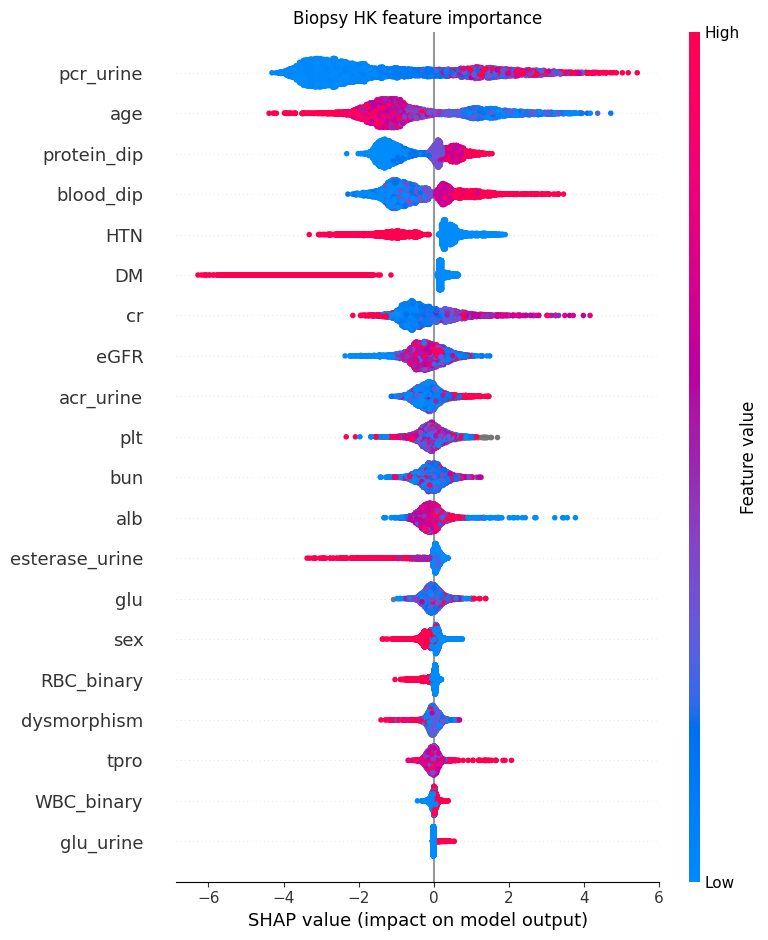

In [10]:
plt.figure(figsize=[10,10])

plt.title('Biopsy HK feature importance')
shap.summary_plot(shap_values, X_train)

plt.show()

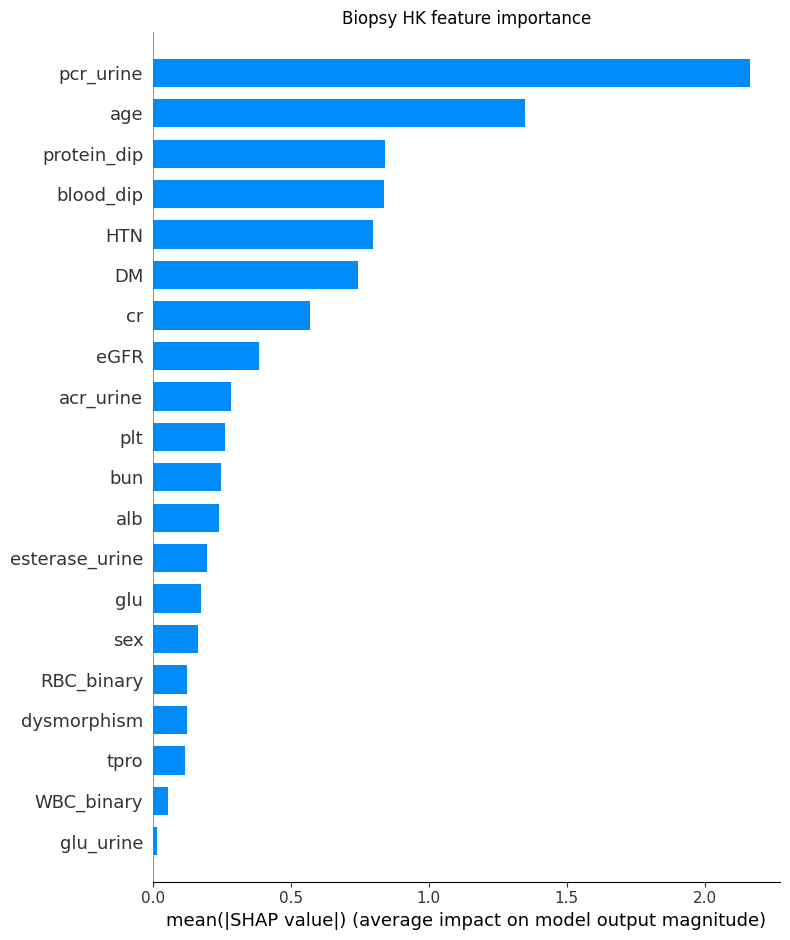

In [11]:
plt.figure(figsize=[10,10])

plt.title('Biopsy HK feature importance')
shap.summary_plot(shap_values, X_train, plot_type="bar")
plt.show()


In [12]:
train_pred = xgb.predict(X_train)
train_pred_prob = xgb.predict_proba(X_train)

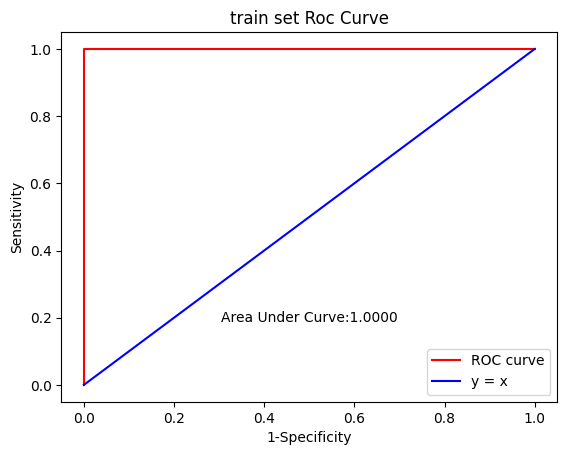

In [13]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(y_train), train_pred_prob[:,1])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(y_train), train_pred_prob[:,1])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('train set Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [14]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5327
           1       1.00      1.00      1.00       844

    accuracy                           1.00      6171
   macro avg       1.00      1.00      1.00      6171
weighted avg       1.00      1.00      1.00      6171



## Validation

In [15]:
pred = xgb.predict(X_valid)
print(pd.DataFrame(pred).head())

pred_prob = xgb.predict_proba(X_valid)
print(pd.DataFrame(pred_prob[:,1]).head())

   0
0  0
1  0
2  0
3  1
4  0
          0
0  0.000030
1  0.096669
2  0.000009
3  0.972342
4  0.000173


In [16]:
pred_prob.shape

(411, 2)

In [17]:
y_valid

0      0
1      0
2      0
3      1
4      0
      ..
406    1
407    0
408    1
409    0
410    0
Name: Biopsy_HK, Length: 411, dtype: int64

In [18]:
accuracy = accuracy_score(y_valid, pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 93.43%


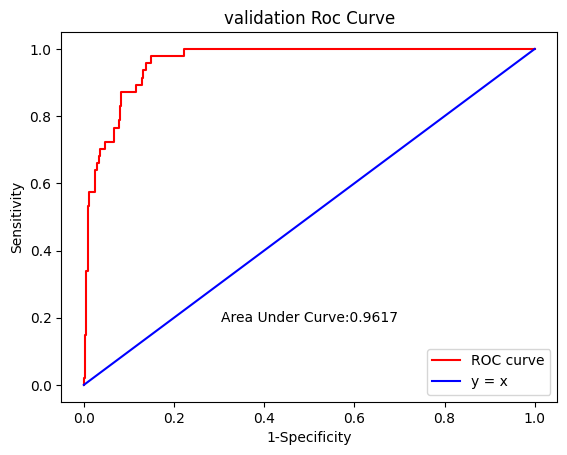

In [19]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(y_valid), pred_prob[:,1])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(y_valid), pred_prob[:,1])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('validation Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [20]:
print(classification_report(y_valid, pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       364
           1       0.72      0.70      0.71        47

    accuracy                           0.93       411
   macro avg       0.84      0.83      0.84       411
weighted avg       0.93      0.93      0.93       411



#### test

In [21]:
test_pred = xgb.predict(X_test)
test_pred_prob = xgb.predict_proba(X_test)

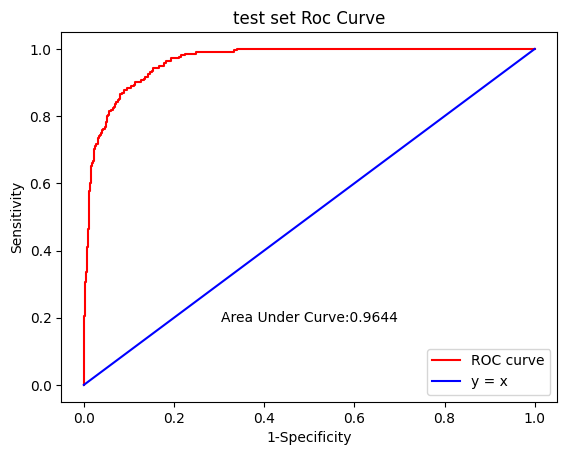

In [22]:
# roc curve, auc validation set
fpr, tpr, thresholds = roc_curve(np.array(y_test), test_pred_prob[:,1])

# auc 계산

plt.plot(fpr, tpr, color = 'red', label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'blue', label = 'y = x') # y = x 직선 표시

auc = roc_auc_score(np.array(y_test), test_pred_prob[:,1])
plt.text(0.5, 0.2, f"Area Under Curve:{auc:.4f}", ha='center', va='center', fontsize=10)
plt.title('test set Roc Curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')

plt.legend() # 그래프 라벨 표시

plt.show()

In [23]:
accuracy = accuracy_score(y_test, test_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.05%


In [24]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1431
           1       0.82      0.70      0.75       215

    accuracy                           0.94      1646
   macro avg       0.89      0.84      0.86      1646
weighted avg       0.94      0.94      0.94      1646



### 비교하기

In [25]:
tt = pd.read_csv('../data/test.csv')
vv = pd.read_csv('../data/validation.csv')

In [26]:
print(tt['hk_proba'])
print(vv['hk_proba'])

0       0.962302
1       0.021136
2       0.996249
3       0.999645
4       0.992675
          ...   
1641    0.959380
1642    0.999774
1643    0.993206
1644    0.995147
1645    0.979208
Name: hk_proba, Length: 1646, dtype: float64
0      0.998615
1      0.652203
2      0.999705
3      0.078725
4      0.998814
         ...   
406    0.006996
407    0.940380
408    0.210982
409    0.917464
410    0.813756
Name: hk_proba, Length: 411, dtype: float64


In [31]:
print(pd.DataFrame(test_pred_prob[:,0]))
print(pd.DataFrame(pred_prob[:,0]))

             0
0     0.995213
1     0.013897
2     0.999905
3     0.999983
4     0.999895
...        ...
1641  0.999740
1642  0.999996
1643  0.999856
1644  0.999879
1645  0.998084

[1646 rows x 1 columns]
            0
0    0.999994
1    0.675745
2    0.999997
3    0.013117
4    0.999560
..        ...
406  0.005170
407  0.910760
408  0.403176
409  0.998016
410  0.995050

[411 rows x 1 columns]
